**Задача:** Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения.

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

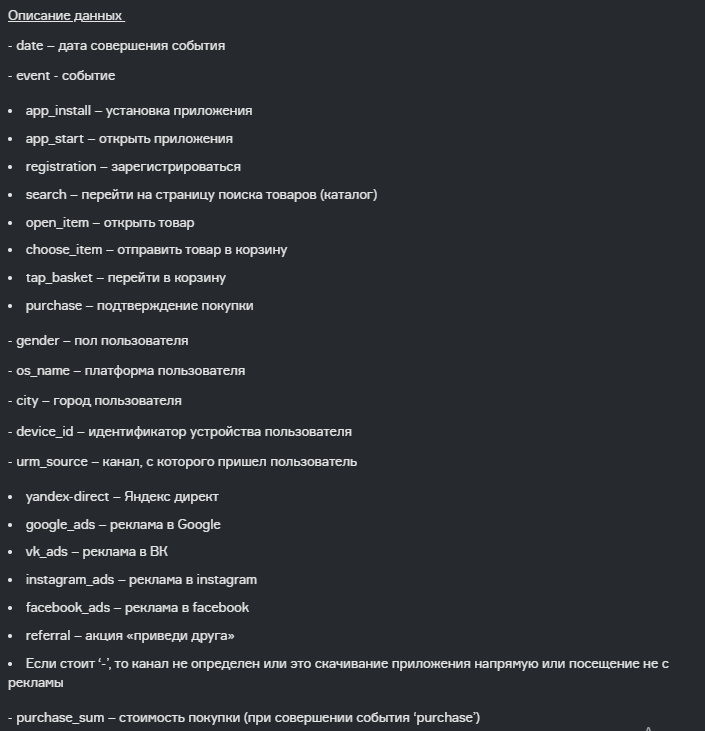

In [17]:
import pandas as pd

In [18]:
df = pd.read_csv('KC_case_data.csv', parse_dates = ['date'])

In [3]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   event         object        
 2   purchase_sum  float64       
 3   os_name       object        
 4   device_id     int64         
 5   gender        object        
 6   city          object        
 7   utm_source    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 167.7+ MB


In [16]:
# колонки содерж. Nan значения 
df.columns[df.isna().any()].tolist()

['purchase_sum']

### Посчитайте MAU февраля.

In [8]:
MAU = df[df.date.dt.month == 2].query('event=="app_start"').device_id.nunique()
print('MAU(февраля) =',MAU)

MAU(февраля) = 75032


### Посчитайте количество установок в январе.

In [9]:
number_of_install = df[df.date.dt.month == 1].query('event=="app_install"').shape[0]
print('Количество установок приложения в январе',number_of_install )

Количество установок приложения в январе 80297


### С какого платного маркетингового канала пришло больше всего новых пользователей? 

In [11]:
df.query('event == "app_install"').utm_source.value_counts()
# c Яндекс

-                32460
yandex-direct    29368
google_ads       26286
vk_ads           23189
instagram_ads    20096
facebook_ads     13916
referal           9282
Name: utm_source, dtype: int64

### Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей?

То есть считаем пользователя сконвертировавшимся, если от момента установки до момента первой покупки прошло не больше 7 дней.

In [5]:
# таблица с датами первых заказов
first_orders = df.query('event == "purchase"')\
                .drop_duplicates('device_id')\
                .groupby('device_id', as_index = False)\
                .agg({'date': 'min'})\
                .rename(columns = {'date':'date_first_order'})
first_orders

,device_id,date_first_order
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07
...,...,...
70870,35321120,2020-03-25
70871,35326839,2020-03-28
70872,35342310,2020-03-27
70873,35367797,2020-03-29


In [4]:
# таблица с датами установки
install = df.query('event == "app_install"')\
            .drop_duplicates('device_id')\
            .groupby(['date','device_id'], as_index = False)\
            .agg({'date': 'min'})\
            .rename(columns = {'date':'date_install'})
install

,device_id,date_install
0,4378,2020-01-01
1,4505,2020-01-01
2,4520,2020-01-01
3,5248,2020-01-01
4,5524,2020-01-01
...,...,...
154592,35315632,2020-03-31
154593,35370030,2020-03-31
154594,35380796,2020-03-31
154595,35388218,2020-03-31


In [6]:
# объединим таблицу с датами установки и первых заказов
union = install.merge(first_orders, on = 'device_id')
union

,device_id,date_install,date_first_order
0,4378,2020-01-01,2020-01-01
1,4505,2020-01-01,2020-01-01
2,4520,2020-01-01,2020-01-06
3,5248,2020-01-01,2020-01-26
4,5524,2020-01-01,2020-01-10
...,...,...,...
57453,34964615,2020-03-31,2020-03-31
57454,35057676,2020-03-31,2020-03-31
57455,35171283,2020-03-31,2020-03-31
57456,35315632,2020-03-31,2020-03-31


In [7]:
#  оставим только те заказы, где разница между датой первого заказа и датой установки меньше 7 дней
union = union[union.date_first_order - union.date_install <= '7 days']
union

,device_id,date_install,date_first_order
0,4378,2020-01-01,2020-01-01
1,4505,2020-01-01,2020-01-01
2,4520,2020-01-01,2020-01-06
6,6309,2020-01-01,2020-01-06
8,6486,2020-01-01,2020-01-01
...,...,...,...
57453,34964615,2020-03-31,2020-03-31
57454,35057676,2020-03-31,2020-03-31
57455,35171283,2020-03-31,2020-03-31
57456,35315632,2020-03-31,2020-03-31


In [9]:
# посчитаем получившихся пользователей, сгруппировав по дате установки 
count_users_buy_for_7days = union.groupby('date_install', as_index = False)\
                                .agg({'device_id':'count'})\
                                .rename(columns = {'device_id':'count_users_2'})
count_users_buy_for_7days

,date_install,count_users_2
0,2020-01-01,1408
1,2020-01-02,1186
2,2020-01-03,834
3,2020-01-04,639
4,2020-01-05,587
...,...,...
86,2020-03-27,277
87,2020-03-28,209
88,2020-03-29,223
89,2020-03-30,204


In [8]:
# посчитаем, сколько всего пользователей установило приложение, сгруппировав по датам установки 
count_users_install_of_day = df.query('event == "app_install"')\
                                .drop_duplicates('device_id')\
                                .groupby('date', as_index = False)\
                                .agg({'device_id':'count'})\
                                .rename(columns = {'device_id' : 'count_users', 'date':'date_install'})

count_users_install_of_day

,date_install,count_users
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671
...,...,...
86,2020-03-27,1199
87,2020-03-28,1091
88,2020-03-29,1117
89,2020-03-30,994


In [10]:
# объединим два датафрейма для подсчёта конверсии 
kogort = count_users_buy_for_7days.merge(count_users_install_of_day, on = 'date_install')
kogort

,date_install,count_users_2,count_users
0,2020-01-01,1408,3579
1,2020-01-02,1186,3144
2,2020-01-03,834,2402
3,2020-01-04,639,1831
4,2020-01-05,587,1671
...,...,...,...
86,2020-03-27,277,1199
87,2020-03-28,209,1091
88,2020-03-29,223,1117
89,2020-03-30,204,994


In [11]:
# считаем конверсию
kogort['conversion'] = kogort.count_users_2/kogort.count_users

In [12]:
# сортируем по возрастанию конверсии
kogort = kogort.sort_values('conversion', ascending = False)
kogort

,date_install,count_users_2,count_users,conversion
0,2020-01-01,1408,3579,0.393406
8,2020-01-09,558,1424,0.391854
14,2020-01-15,1650,4310,0.382831
13,2020-01-14,1973,5173,0.381403
1,2020-01-02,1186,3144,0.377226
...,...,...,...,...
77,2020-03-18,235,1171,0.200683
88,2020-03-29,223,1117,0.199642
81,2020-03-22,251,1261,0.199048
87,2020-03-28,209,1091,0.191567


In [13]:
# найдём конверсию в процентах
kogort['conversion,%'] = kogort['conversion']*100
kogort['conversion,%'] = kogort['conversion,%'].round(1)
kogort

,date_install,count_users_2,count_users,conversion,"conversion,%"
0,2020-01-01,1408,3579,0.393406,39.3
8,2020-01-09,558,1424,0.391854,39.2
14,2020-01-15,1650,4310,0.382831,38.3
13,2020-01-14,1973,5173,0.381403,38.1
1,2020-01-02,1186,3144,0.377226,37.7
...,...,...,...,...,...
77,2020-03-18,235,1171,0.200683,20.1
88,2020-03-29,223,1117,0.199642,20.0
81,2020-03-22,251,1261,0.199048,19.9
87,2020-03-28,209,1091,0.191567,19.2


#### Для когорты от "2020-01-01" конверсия была наибольшей.

### Проанализируйте на каком этапе воронки отваливается большая часть зарегистрированных пользователей?

Посчитаем конверсию на каждом шаге воронки. Ответом будет тот шаг воронки, конверсия из которого в следующий шаг наименьшая.

Сначала определим, зарегистрирован пользователь или нет, если дата регистрации < даты совершения события, то пользователь уже зарегистрирован.

In [5]:
# определим дату регистрации для каждого пользователя

first_registration = df.query('event == "register"')\
                        .sort_values('date')\
                        .drop_duplicates('device_id')

# добавим колонку с датой регистрации
df['first_registration'] = df['device_id'].map(first_registration.set_index('device_id')['date'])

In [6]:
# определяем уже зарегистрированных пользователей
already_registration = df[df['first_registration'] < df['date']]

In [8]:
already_registration.groupby('event')['device_id'].nunique()

event
app_start      40991
choose_item    37926
purchase       24880
search         40482
tap_basket     34517
Name: device_id, dtype: int64

Считаем конверсию на каждом шаге воронки.

In [13]:
print('Конверсия в поиск из открытия приложения', round((40482/40991)*100, 2),'%')

Конверсия в поиск из открытия приложения 98.76 %


In [12]:
print('Конверсия в добавление товара в корзину из поиска', round((37926/40482)*100, 2),'%')

Конверсия в добавление товара в корзину из поиска 93.69 %


In [14]:
print('Конверсия в переход в корзину из добавления товара', round((34517/37926)*100, 2),'%')

Конверсия в переход в корзину из добавления товара 91.01 %


In [15]:
print('Конверсия в покупку из перехода в корзину', round((24880/34517)*100, 2),'%')

Конверсия в покупку из перехода в корзину 72.08 %


При переходе из корзины к покупке отваливается больше всего зарегистрированых пользователей, поскольку конверсия на этом этапе воронки минимальна.

### Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?


- CR = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

In [131]:
# определим пользователей, совершивших первую покупку
purchase = df.query('event == "purchase"')\
            .groupby('device_id', as_index = False)\
            .agg({'date':'min'})

In [132]:
df_1= df.merge(purchase, on = 'device_id')

In [133]:
# кол-во юзеров, впервые совершивших покупку
df_1 = df_1.groupby('utm_source', as_index = False)\
            .agg({'device_id':pd.Series.nunique})\
            .rename(columns = {'device_id':'count_users_df_1'})

In [134]:
# определим пользователей, впервые открывших приложение 
app_start = df.query('event == "app_start"')\
                .groupby('device_id', as_index = False)\
                .agg({'date':'min'})

In [135]:
df_2 = df.merge(app_start, on = 'device_id')

In [136]:
# кол-во юзеров, впервые открывших приложение
df_2 = df_2.groupby('utm_source', as_index = False)\
            .agg({'device_id':pd.Series.nunique})\
            .rename(columns = {'device_id':'count_users_df_2'})

In [137]:
# соединяем фреймы

union_frame  = df_1.merge(df_2, on = 'utm_source')
union_frame

,utm_source,count_users_df_1,count_users_df_2
0,-,21452,52273
1,facebook_ads,11470,25959
2,google_ads,15303,38096
3,instagram_ads,13635,31048
4,referal,7818,15926
5,vk_ads,15565,34086
6,yandex-direct,16259,40712


In [138]:
# Считаем конверсию как CR = df_1 / df_2

union_frame['CR,%'] = round((union_frame.count_users_df_1/union_frame.count_users_df_2)*100, 2)
union_frame.sort_values('CR,%')

,utm_source,count_users_df_1,count_users_df_2,"CR,%"
6,yandex-direct,16259,40712,39.94
2,google_ads,15303,38096,40.17
0,-,21452,52273,41.04
3,instagram_ads,13635,31048,43.92
1,facebook_ads,11470,25959,44.19
5,vk_ads,15565,34086,45.66
4,referal,7818,15926,49.09


Пользователи, пришедшие с yandex-direct, показали самую низкую конверсию в первую покупку

### Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? (учитываются только первые покупки пользователей)

Определим пользователей, совершивших первую покупку и посчитаем медианный чек с разбивкой по каналам.

In [122]:
df.query('event == "purchase"')\
    .sort_values('date')\
    .drop_duplicates('device_id')\
    .groupby('utm_source', as_index = False)\
    .agg({'purchase_sum':'median' })\
    .rename(columns = {'purchase_sum' : 'median_check'})

,utm_source,median_check
0,-,398.5
1,facebook_ads,389.0
2,google_ads,390.5
3,instagram_ads,393.5
4,referal,395.5
5,vk_ads,393.0
6,yandex-direct,392.5


Пользователи, пришедшие с реферальной программы, имеют медианный первый чек выше, чем у остальных.

### Какой платный канал привлечения имеет самый высокий ROMI? 

`Данные по затратам на рекламу:`

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей.

- ROMI = (Выручка − Расход на рекламу) / Расход на рекламу × 100%

In [140]:
# выберем необходимые каналы привлечениы и посчитаем выручку

sum_purchase= df.query('event == "purchase" & utm_source in ("yandex-direct", "google_ads", "facebook_ads", "instagram_ads", "vk_ads")')\
        .groupby(['utm_source'], as_index = False)\
        .agg({'purchase_sum':'sum'})
sum_purchase.head()

,utm_source,purchase_sum
0,facebook_ads,12249901.0
1,google_ads,12868276.0
2,instagram_ads,14546969.0
3,vk_ads,16389652.5
4,yandex-direct,13915368.0


In [143]:
# внесём расходы на маркетинг
sum_purchase.at[0:5, 'marketing'] = 8590498, 10534878, 8561626, 9553531, 10491707

In [144]:
sum_purchase

,utm_source,purchase_sum,marketing
0,facebook_ads,12249901.0,8590498
1,google_ads,12868276.0,10534878
2,instagram_ads,14546969.0,8561626
3,vk_ads,16389652.5,9553531
4,yandex-direct,13915368.0,10491707


In [39]:
# посчитаем ROMI

sum_purchase['ROMI,%'] = ((sum_purchase.purchase_sum - sum_purchase.marketing)*100/sum_purchase.marketing)\
                        .round(1)
sum_purchase = sum_purchase.sort_values('ROMI,%', ascending = False)

sum_purchase

,utm_source,purchase_sum,marketing,"ROMI,%"
3,vk_ads,16389652.5,9553531,71.6
2,instagram_ads,14546969.0,8561626,69.9
0,facebook_ads,12249901.0,8590498,42.6
4,yandex-direct,13915368.0,10491707,32.6
1,google_ads,12868276.0,10534878,22.1


Самая высокая отдача на вложенные инвестиции в маркетинг у канала "ВК"